In [1]:
# !pip install pandas pymongo bertopic spacy --quiet

In [1]:
spacy_model_name = "de_core_news_md"
#!python -m spacy download {spacy_model_name} --quiet

In [2]:
import os
from pathlib import Path

import numpy as np
import openai
import pandas as pd
import spacy

from datetime import datetime
from dotenv import load_dotenv
from pymongo import MongoClient, errors
from tqdm import tqdm

# bertopic components
from bertopic import BERTopic
from bertopic.representation import OpenAI
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

load_dotenv("../.env")

/home/mirza/miniconda3/envs/medialab-env/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/mirza/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Data extraction

In [3]:
MONGO_DATABASE = 'insightfinder-dev'
MONGO_COLLECTION = 'content'
MONGO_HOST = os.getenv("MONGO_HOST")

In [4]:
def generate_data(query: dict, projection: dict = None, sort_order: list = None, limit: int = None):
    try:
        with MongoClient(MONGO_HOST) as mongo_client:
            db = mongo_client[MONGO_DATABASE]
            collection = db[MONGO_COLLECTION]
            res = collection.find(query, projection or {})
            if sort_order:
                res = res.sort(sort_order)
            if limit:
                res = res.limit(limit)
            yield from res
    except errors.PyMongoError as e:
        self.logger.error(f"MongoDB error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


def preprocess_paragraphs(paragraphs):
    if not isinstance(paragraphs, list):
        return None
    return " ".join(p.strip() for p in paragraphs if len(p.strip()) > 0)

In [7]:
query = {"visited": True, "parsed_date": {"$exists": True, "$ne": None, "$gte": "2024-05-20"}}
projection = {"_id": 1, "url": 1, "parsed_date": 1, "title": 1, "description": 1, "paragraphs": 1, "site_name": 1}
sort_order = None #[("parsed_date", -1)]
limit = None

data_generator = generate_data(query, projection, sort_order, limit)
df = pd.DataFrame(data_generator)
df["paragraphs"] = df["paragraphs"].apply(preprocess_paragraphs)

In [8]:
df

,_id,url,site_name,description,paragraphs,title,parsed_date
0,66448d4104262132d03e128d,https://www.handelsblatt.com/finanzen/vorsorge...,handelsblatt,"Während in Europa vieles immer teurer wird, si...",Koh Samui. Den unverstellten Meerblick von sei...,So lebt ein deutscher Rentner mit 1800 Euro pr...,2024-05-24
1,66448e35a8661d2ff5eba7b6,https://www.handelsblatt.com/finanzen/maerkte/...,handelsblatt,Die Marke von 19.000 Punkten erweist sich für ...,Frankfurt. Beim Dax geht es aktuell vor allem ...,"Sechs Punkte, die für Anleger heute wichtig sind",2024-05-24
2,6652e2429bcb9c2c563cbed6,https://www.spiegel.de/panorama/sylt-spd-zieht...,spiegel,"»Deutschland den Deutschen, die unsere Demokra...",Mit einem Instagram-Post wollte die SPD das ra...,SPD zieht Insta-Post zum rassistischen Sylt-Ge...,2024-05-25
3,6652e2429bcb9c2c563cbed7,https://www.spiegel.de/ausland/sudan-krieg-der...,spiegel,"16.000 Tote, 33.000 Verletzte und neun Million...",Die Lage im Sudan droht ein Jahr nach Beginn d...,Uno warnt vor Genozid im Sudan,2024-05-24
4,6652e2429bcb9c2c563cbed8,https://www.spiegel.de/ausland/us-verteidigung...,spiegel,Wegen einer »minimalinvasiven« Behandlung an s...,US-Verteidigungsminister Lloyd Austin übergibt...,US-Verteidigungsminister gibt erneut Geschäfte...,2024-05-24
...,...,...,...,...,...,...,...
33938,66a660d1ff627695746154fe,https://www.tagesschau.de/ausland/europa/belar...,tagesschau,"Vor wenigen Tagen wurde bekannt, dass in Belar...","Vor wenigen Tagen wurde bekannt, dass in Belar...",Belarus führt zum Tode verurteilten Deutschen vor,2024-07-26
33939,66a660d4ff627695746154ff,https://www.tagesschau.de/inland/scholz-grenzk...,tagesschau,Der Kanzler hält Erwerbsmigration für nötig un...,Der Kanzler hält Erwerbsmigration für nötig un...,Scholz setzt weiter auf strikte,2024-07-26
33940,66a660d7ff62769574615500,https://www.tagesschau.de/ausland/festnahmen-s...,tagesschau,Das Sinaloa-Kartell gilt als eine der mächtigs...,Das Sinaloa-Kartell gilt als eine der mächtigs...,Anführer des Sinaloa-Kartells verhaftet,2024-07-26
33941,66a660daff62769574615501,https://www.tagesschau.de/ausland/waldbraende-...,tagesschau,In Kanada ist die Waldbrandsaison in vollem Ga...,In Kanada ist die Waldbrandsaison in vollem Ga...,Waldbrand zerstört viele Gebäude in Kleinstadt,2024-07-26


In [9]:
df["site_name"].value_counts()

site_name
tagesspiegel    16447
spiegel          7700
handelsblatt     3007
heise            2548
faz              2418
tagesschau       1823
Name: count, dtype: int64

# Prepare data

In [10]:
def build_documents(record):
    components = [record.get("title"), record.get("description"), record.get("paragraphs")]
    document = " ".join(c.strip() for c in components if c is not None and len(c.strip()) > 0)
    document = document.strip()
    return document

In [11]:
df["document"] = df.apply(build_documents, axis=1)
df["document"].apply(len).describe()

count    33943.000000
mean      2419.651092
std       1997.361676
min          0.000000
25%       1041.000000
50%       2012.000000
75%       3190.000000
max      37196.000000
Name: document, dtype: float64

In [12]:
df = df.loc[df["document"].str.len() > 0]
df.shape

(33914, 8)

In [13]:
nlp = spacy.load(spacy_model_name)

def preprocess_documents(document):
    doc = nlp(document)
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop and not token.is_punct and not token.is_digit and token.lemma_.strip()
    ]
    document = " ".join(tokens)
    return document


tqdm.pandas()
df["processed_document"] = df["document"].progress_apply(preprocess_documents)
df["processed_document"].apply(len).describe()

 26%|█████████▉                            | 8896/33914 [04:10<11:45, 35.48it/s]


KeyboardInterrupt: 

In [62]:
df.document.iloc[1]

'Sandkastenstreit zwischen Sunak und Starmer In der Debatte: Keri Starmer (links) streitet mit Rishi Sunak Für britische Zuschauer sind Wahlkampfduelle ihrer Spitzenkandidaten im Fernsehen ein weniger seltenes und sensationelles Phänomen als in anderen demokratischen Ländern. Sie kennen solche rhetorischen Kämpfe der beiden Kontrahenten aus dem Parlament. Denn dort stehen sich jeden Mittwoch der Premierminister und der Oppositionsführer gegenüber, wenn im Zuge der „Fragen an den Premierminister“ der letztere den ersteren politisch in die Enge zu treiben sucht. Im Falle des Labour-Oppositionschefs Keir Starmer und des konservativen Premierministers Rishi Sunak schien es bei ihrem ersten Fernseh-Wettkampf am Dienstagabend eine ganze Weile so, als stünden die beiden noch immer in dem grünledernen Plenarsaal, anstatt in einem gläsernen Fernsehstudio. Eine Moderatorin des Senders ITV nannte ihnen Stichworte, das Publikum stellte vorher ausgewählte Fragen, aber die Reflexe Starmers und Sunak

In [63]:
df.processed_document.iloc[1]

'sandkastenstreit sunak starmer debatte keri starmer links streiten rishi sunak britisch zuschauer wahlkampfduelle spitzenkandidat fernsehen selten sensationell phänomen demokratisch land kennen rhetorisch kampf kontrahent parlament stehen mittwoch premierminister oppositionsführer zug frage premierminister letzterer ersterer politisch enge treiben suchen fall labour-oppositionschef keir starmer konservativ premierminister rishi sunak scheinen fernseh-wettkampf dienstagabend weile stehen grünledern plenarsaal anstatt gläsern fernsehstudio moderatorin sender itv nennen stichwort publikum stellen vorher ausgewählt frage reflex starmer sunak parlamentsdebatt funktionieren zuverlässig selten antwort geben meist jeweils anschuldigung überzogen starmer falsch rolle fernsehkamera oppositionsführer wirken künftig premierminister geben beginnen auftritt selbstsicheren satz land vierzehn konservativ misswirtschaft reif wechsel anschließend verbringen zugewiesen redezeit fast vollständig vermeint

# Topic modelling

In [81]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine")
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True)
vectorizer_model = CountVectorizer(min_df=10, ngram_range=(1, 3))

topic_model = BERTopic(
    embedding_model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    umap_model=umap_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer_model,
    verbose=True,
)

In [82]:
documents = df.processed_document.tolist()

topics, probs = topic_model.fit_transform(documents)

2024-06-20 22:31:12,011 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/138 [00:00<?, ?it/s]

2024-06-20 22:32:00,445 - BERTopic - Embedding - Completed ✓
2024-06-20 22:32:00,445 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-20 22:32:04,299 - BERTopic - Dimensionality - Completed ✓
2024-06-20 22:32:04,300 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-20 22:32:04,417 - BERTopic - Cluster - Completed ✓
2024-06-20 22:32:04,421 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-20 22:32:06,271 - BERTopic - Representation - Completed ✓


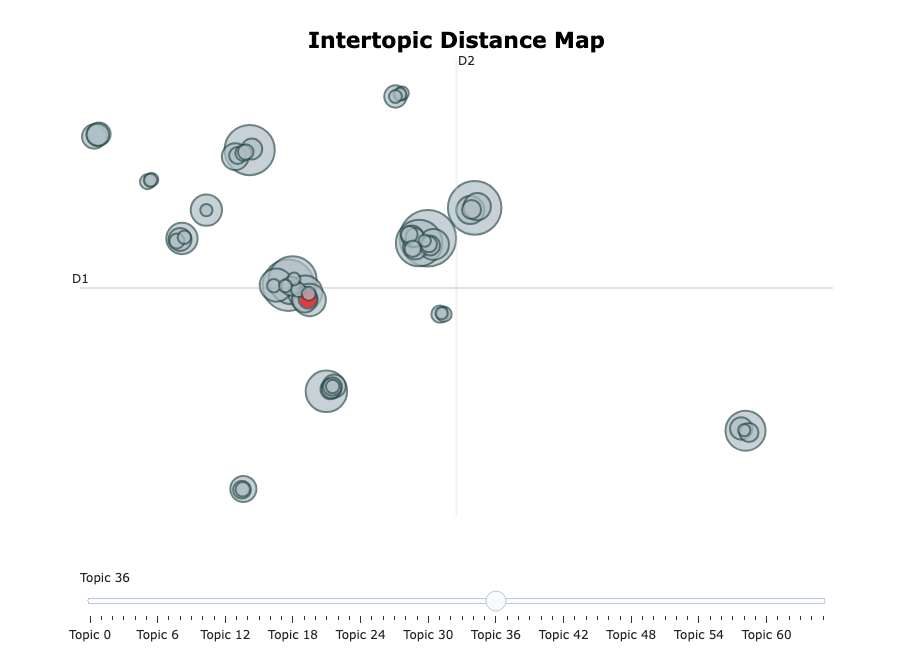

In [83]:
topic_model.visualize_topics()

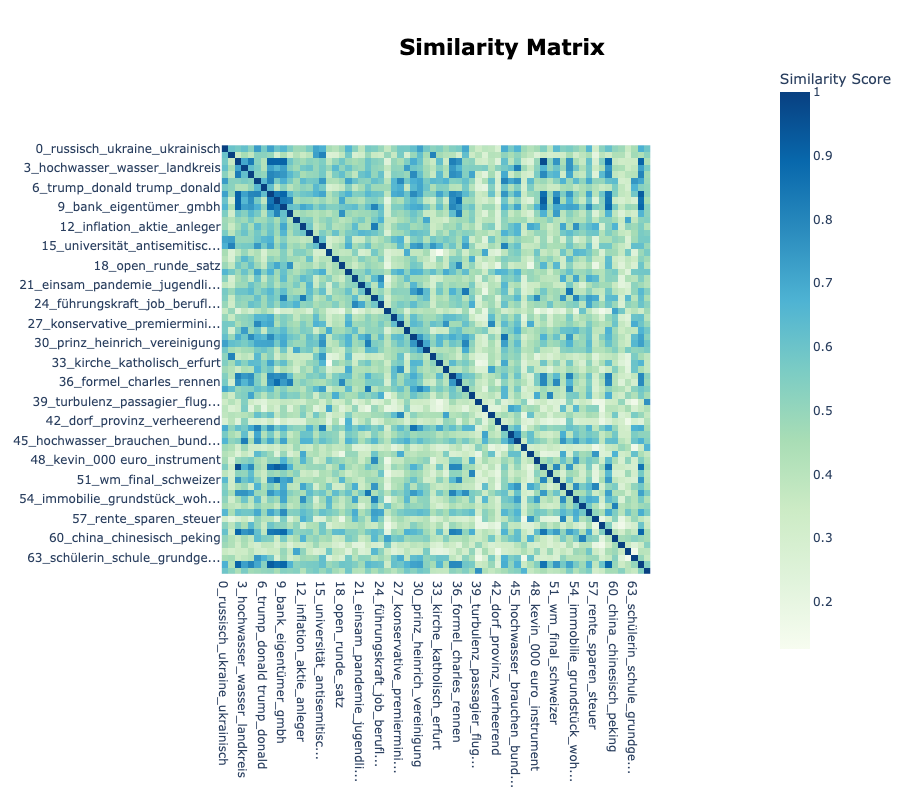

In [84]:
topic_model.visualize_heatmap()

## Topics over time

In [87]:
openai_client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
openai_model = OpenAI(
    openai_client,
    model="gpt-3.5-turbo",
    chat=True,
    tokenizer="char",
    doc_length=500,
    nr_docs=5,
)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine")
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True)
vectorizer_model = CountVectorizer(min_df=10, ngram_range=(1, 3))

topic_model = BERTopic(
    embedding_model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    umap_model=umap_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer_model,
    representation_model=openai_model,
    verbose=True,
)

In [93]:
documents = df.processed_document.tolist()
dates = pd.to_datetime(df.parsed_date).tolist()

topics, probs = topic_model.fit_transform(documents)
topics_over_time = topic_model.topics_over_time(documents, dates, nr_bins=7)

2024-06-20 22:38:29,076 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/138 [00:00<?, ?it/s]

2024-06-20 22:39:10,587 - BERTopic - Embedding - Completed ✓
2024-06-20 22:39:10,588 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-20 22:39:14,598 - BERTopic - Dimensionality - Completed ✓
2024-06-20 22:39:14,598 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-20 22:39:14,707 - BERTopic - Cluster - Completed ✓
2024-06-20 22:39:14,709 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|                                                                                          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|████████████████████████████████████████████████████████████████

In [104]:
sd, ed = df.parsed_date.min(), df.parsed_date.max()
sd = datetime.strptime(sd, "%Y-%m-%d").strftime("%y%m%d")
ed = datetime.strptime(ed, "%Y-%m-%d").strftime("%y%m%d")

output_path = Path(f"./data/topics/v2/topics_over_time_{sd}-{ed}.csv")
output_path.parent.mkdir(exist_ok=True, parents=True)
topics_over_time.to_csv(output_path, index=False)

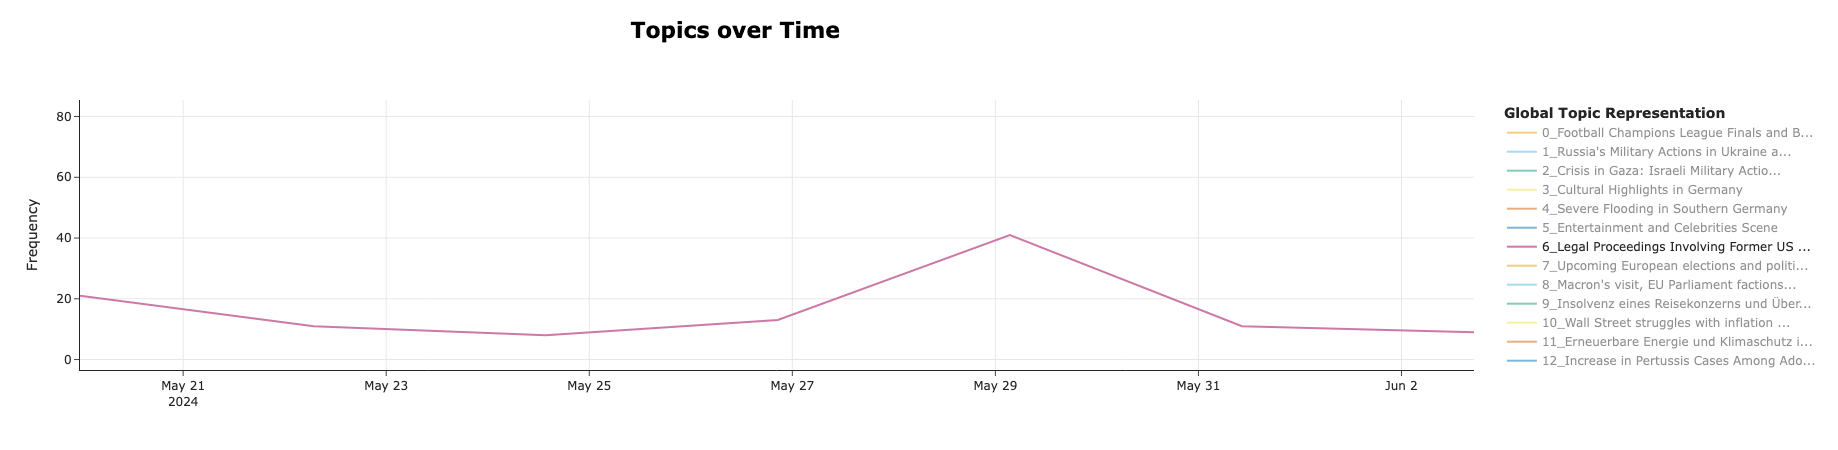

In [95]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [97]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
0,-1,The Impact of Artificial Intelligence on Vario...,218,2024-05-19 23:36:57.600000000,-1_Europa's political landscape and soci...
1,0,Football Season Highlights and Transfers,81,2024-05-19 23:36:57.600000000,0_Football Champions League Finals and B...
2,1,"Conflict in Ukraine - Russian aggression, Ukra...",42,2024-05-19 23:36:57.600000000,1_Russia's Military Actions in Ukraine a...
3,2,Tensions between Israel and Hamas in Gaza Strip,47,2024-05-19 23:36:57.600000000,2_Crisis in Gaza: Israeli Military Actio...
4,3,Literary celebration and artistic storytelling...,32,2024-05-19 23:36:57.600000000,3_Cultural Highlights in Germany
...,...,...,...,...,...
364,54,Public Transport Innovation and Development,2,2024-06-02 17:08:34.285714285,54_German rail transport infrastructure ...
365,56,Military tensions between South Korea and Nort...,2,2024-06-02 17:08:34.285714285,56_Nordkorea Raketenaktionen und Müllbal...
366,57,Podcast Availability and Feedback on Putin's A...,1,2024-06-02 17:08:34.285714285,57_German politics podcast discussions a...
367,58,Aircraft Maintenance and Defense Strategy in H...,2,2024-06-02 17:08:34.285714285,58_Aviation Incidents and Safety Measure...


In [103]:
df["predicted_topic"] = topics

output_path = Path(f"./data/topics/v2/predicted_topics_{sd}-{ed}.csv")
output_path.parent.mkdir(exist_ok=True, parents=True)
outcols = ["_id", "url", "title", "description", "paragraphs", "predicted_topic"]
df[outcols].to_csv(output_path, index=False)

In [102]:
df.loc[df["predicted_topic"] == 6]

,_id,url,site_name,description,paragraphs,parsed_date,title,document,processed_document,predicted_topic
245,665f91a59fe76ab696a3145d,https://www.handelsblatt.com/politik/internati...,handelsblatt,Im Schweigegeldprozess gegen den Ex-Präsidente...,"New York, Washington. Das Leben von Juan Merch...",2024-06-04,"Dieser Mann entscheidet, ob Trump ins Gefängni...","Dieser Mann entscheidet, ob Trump ins Gefängni...",mann entscheiden trump gefängnis schweigegeldp...,6
329,666063cc24924b2f2d3d31de,https://www.spiegel.de/ausland/usa-sohn-von-re...,spiegel,John Rose hat im US-Kongress eine denkwürdige ...,Ein Sechsjähriger stiehlt dem Vater die Show: ...,2024-06-04,"Papa verteidigt Trump, der Sohn schneidet Grim...","Papa verteidigt Trump, der Sohn schneidet Grim...",papa verteidigen trump sohn schneiden grimasse...,6
425,6660651024924b2f2d3d324d,https://www.spiegel.de/ausland/donald-trump-ur...,spiegel,Juristisch war der New Yorker Prozess eine Ple...,Es war ein historischer Tag in New York City: ...,2024-06-04,Urteil spült Donald Trump Millionen in die Wah...,Urteil spült Donald Trump Millionen in die Wah...,urteil spülen donald trump million wahlkampfka...,6
454,665f2c3f16149b97234e035d,https://www.faz.net/aktuell/politik/ausland/do...,faz,Der frühere amerikanische Präsident Donald Tru...,Der frühere amerikanische Präsident Donald Tru...,2024-06-03,"„Ich bin damit einverstanden, aber die Öffentl...","„Ich bin damit einverstanden, aber die Öffentl...",einverstanden öffentlichkeit früh amerikanisch...,6
485,665f316add5229563ceb87b0,https://www.faz.net/aktuell/feuilleton/medien/...,faz,Vor dem Trump Tower in New York fordert ein De...,Das Urteil gegen Donald Trump im Schweigegeldp...,2024-06-03,Stimmen Sie für das Gesetz oder für einen veru...,Stimmen Sie für das Gesetz oder für einen veru...,stimme gesetz verurteilt verbrecher trump towe...,6
...,...,...,...,...,...,...,...,...,...,...
4278,6655ff6f17297ee894b2bcca,https://www.faz.net/aktuell/feuilleton/entsche...,faz,Unterstützer Assanges vor dem High Court in Lo...,Im juristischen Tauziehen um die von den USA g...,2024-05-20,Wegweisendes Urteil in London erwartet,Wegweisendes Urteil in London erwartet Unterst...,wegweisendes urteil london erwarten unterstütz...,6
4340,665f5a70d985b75c8f4079d1,https://www.tagesschau.de/kommentar/verfahren-...,tagesschau,"Dass er in Berufung gehen kann, ist ein Sieg f...","Dass er in Berufung gehen kann, ist ein Sieg f...",2024-05-20,Lasst Assange frei!,Lasst Assange frei! Dass er in Berufung gehen ...,lasst assang frei berufung sieg julian assange...,6
4342,665f5a75d985b75c8f4079d3,https://www.tagesschau.de/ausland/europa/assan...,tagesschau,Es ist ein Etappensieg für WikiLeaks-Gründer A...,Es ist ein Etappensieg für WikiLeaks-Gründer A...,2024-05-20,Assange darf Berufung gegen Auslieferung einlegen,Assange darf Berufung gegen Auslieferung einle...,assange berufung auslieferung einlegen etappen...,6
4368,665f84522349fd20bba2d722,https://www.handelsblatt.com/politik/internati...,handelsblatt,Wikileaks-Gründer Julian Assange kämpft seit J...,Das US-Justizministerium bezeichnete die Enthü...,2024-05-20,Assange darf Berufung gegen Auslieferung an di...,Assange darf Berufung gegen Auslieferung an di...,assange berufung auslieferung usa einlegen wik...,6
